# Importar as bibliotecas necessárias
# Baixar os conjuntos de dados e salvar em formato .csv para acesso offline

In [1]:
import basedosdados as bd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
sns.set_theme (style='whitegrid', font_scale=2)
PROJECT_ID = 'YOUR_PROJECT_ID'

import numpy as np
import time
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import keras
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
TEST_SIZE = 2/10
TARGET = 'ideb'
STATE = 0 ### K: Reproducibilidade.


#df_pib = bd.read_table (dataset_id='br_ibge_pib', table_id='municipios', billing_project_id=PROJECT_ID) # https://basedosdados.org/dataset/br-ibge-pib
#df_pib.to_csv (path_or_buf='br_ibge_pib.csv', index=False)
#df_inflacao = bd.read_table (dataset_id='br_ibge_inflacao', table_id='ipca15', billing_project_id=PROJECT_ID) # https://basedosdados.org/dataset/br-ibge-inflacao
#df_inflacao.to_csv (path_or_buf='br_ibge_inflacao.csv', index=False)
#df_ideb_municipio = bd.read_table (dataset_id='br_inep_ideb', table_id='municipio', billing_project_id=PROJECT_ID)
#df_ideb_municipio.to_csv (path_or_buf='br_ideb_municipio.csv', index=False)
#df_finbra_receitas = bd.read_table (dataset_id='br_tesouro_finbra', table_id='receitas_orcamentarias', billing_project_id=PROJECT_ID)
#df_finbra_receitas.to_csv (path_or_buf='br_finbra_receitas.csv', index=False)
#df_finbra_despesas_orcamentarias = bd.read_table (dataset_id='br_tesouro_finbra', table_id='despesas_orcamentarias', billing_project_id=PROJECT_ID)
#df_finbra_despesas_orcamentarias.to_csv (path_or_buf='br_finbra_despesas_orcamentarias.csv', index=False)
#df_finbra_despesas_por_funcao = bd.read_table (dataset_id='br_tesouro_finbra', table_id='despesas_por_funcao', billing_project_id=PROJECT_ID)
#df_finbra_despesas_por_funcao.to_csv (path_or_buf='br_finbra_despesas_por_funcao.csv', index=False)

# Carregar os conjuntos de dados e limitar o escopo da análise (2005-2018)

In [2]:
#df_finbra_receitas = pd.read_csv ('br_finbra_receitas.csv')
#df_finbra_receitas.drop (df_finbra_receitas [(df_finbra_receitas.ano < 2005) | (df_finbra_receitas.ano > 2018)].index, inplace=True)
#df_finbra_receitas.sort_values (by=['id_municipio', 'ano'], inplace=True)
#df_finbra_receitas [:5]

In [3]:
#df_finbra_despesas_orcamentarias = pd.read_csv ('br_finbra_despesas_orcamentarias.csv')
#df_finbra_despesas_orcamentarias.drop (df_finbra_receitas [(df_finbra_despesas_orcamentarias.ano < 2005) | (df_finbra_despesas_orcamentarias.ano > 2018)].index, inplace=True)
#df_finbra_despesas_orcamentarias.sort_values (by=['id_municipio', 'ano'], inplace=True)
#df_finbra_despesas_orcamentarias [:5]

In [4]:
df_inflacao = pd.read_csv ('br_ibge_inflacao.csv')
df_inflacao.drop (df_inflacao [(df_inflacao.ano < 2005) | (df_inflacao.ano > 2018)].index, inplace=True)
df_inflacao ['data'] = pd.to_datetime(df_inflacao['ano'].astype (str) + df_inflacao['mes'].astype (str), format='%Y%m')
df_inflacao = df_inflacao [['ano', 'mes', 'indice', 'variacao_mes', 'data']]
df_inflacao [:5]

,ano,mes,indice,variacao_mes,data
132,2005,1,2366.78,0.68,2005-01-01
133,2005,2,2384.29,0.74,2005-02-01
134,2005,3,2392.64,0.35,2005-03-01
135,2005,4,2410.35,0.74,2005-04-01
136,2005,5,2430.36,0.83,2005-05-01


In [5]:
df_finbra_despesas_por_funcao = pd.read_csv ('br_finbra_despesas_por_funcao.csv')
df_finbra_despesas_por_funcao.drop (df_finbra_despesas_por_funcao [(df_finbra_despesas_por_funcao.ano < 2005) | (df_finbra_despesas_por_funcao.ano > 2018)].index, inplace=True)
df_finbra_despesas_por_funcao.sort_values (by=['id_municipio', 'ano'], inplace=True)
df_finbra_despesas_por_funcao = df_finbra_despesas_por_funcao [['id_municipio', 'ano', 'coluna', 'conta', 'valor']]
### K: Selecionar todas as despesas relacionadas à educação e à ciência.
### K: Também selecionar apenas as despesas pagas.
#for conta in (df_finbra_despesas_por_funcao ['conta'].unique ()):
#    print (conta)

df_finbra_despesas_por_funcao.drop (df_finbra_despesas_por_funcao 
                                    [(df_finbra_despesas_por_funcao.coluna != 'Despesas Pagas')].index, inplace=True)
df_finbra_despesas_por_funcao.drop (df_finbra_despesas_por_funcao 
                                    [(df_finbra_despesas_por_funcao.conta != 'Educação') &
                                     (df_finbra_despesas_por_funcao.conta != 'Educação Infantil') &
                                     (df_finbra_despesas_por_funcao.conta != 'Ensino Superior') &
                                     (df_finbra_despesas_por_funcao.conta != 'Educação de Jovens e Adultos') &
                                     (df_finbra_despesas_por_funcao.conta != 'Educação Especial') &
                                     (df_finbra_despesas_por_funcao.conta != 'Ensino Profissional') &
                                     (df_finbra_despesas_por_funcao.conta != 'Ensino Médio') &
                                     (df_finbra_despesas_por_funcao.conta != 'Ciência e Tecnologia') &
                                     (df_finbra_despesas_por_funcao.conta != 'Difusão do Conhecimento Científico e Tecnológico') &
                                     (df_finbra_despesas_por_funcao.conta != 'Educação Básica') &
                                     (df_finbra_despesas_por_funcao.conta != 'Transferências para a Educação Básica') &
                                     (df_finbra_despesas_por_funcao.conta != 'Demais Subfunções Ciência e Tecnologia') &
                                     (df_finbra_despesas_por_funcao.conta != 'Educação')].index, inplace=True)
### K: Agregar os gastos por ano.
df_finbra_despesas_por_funcao = df_finbra_despesas_por_funcao.groupby (['id_municipio', 'ano', 'conta'],
                                                                       as_index=False)['valor'].mean()
### K: Renomear "conta" para refletir o tipo do gasto.
df_finbra_despesas_por_funcao.rename (columns={'conta': 'tipo_de_gasto',}, inplace=True)

df_finbra_despesas_por_funcao [:5]

,id_municipio,ano,tipo_de_gasto,valor
0,1100015,2013,Educação,11559592.81
1,1100015,2013,Educação Infantil,813021.40
2,1100015,2014,Educação,14092729.90
3,1100015,2014,Educação Infantil,981753.67
4,1100015,2014,Ensino Superior,406408.01


In [6]:
df_pib = pd.read_csv ('br_ibge_pib.csv')
df_pib.drop (df_pib [(df_pib.ano < 2005) | (df_pib.ano > 2018)].index, inplace=True)
df_pib.sort_values (by=['id_municipio', 'ano'], inplace=True)
df_pib = df_pib [['id_municipio', 'ano', 'PIB']]
df_pib [:5]

,id_municipio,ano,PIB
16680,1100015,2005,167127355
22244,1100015,2006,168805060
27808,1100015,2007,191364329
33372,1100015,2008,248961794
38936,1100015,2009,256986138


In [7]:
df_ideb_municipio = pd.read_csv ('br_ideb_municipio.csv')
df_ideb_municipio.drop (df_ideb_municipio [(df_ideb_municipio.ano < 2005) | (df_ideb_municipio.ano > 2018)].index, inplace=True)
df_ideb_municipio.sort_values (by=['id_municipio', 'ano', 'ensino'], inplace=True)
df_ideb_municipio = df_ideb_municipio [['id_municipio', 'municipio', 'ensino', 'ano', 'ideb']]
### K: Agregar os idebs por ano:
df_ideb_municipio = df_ideb_municipio.groupby (['id_municipio', 'municipio', 'ano'], as_index=False)['ideb'].mean()
df_ideb_municipio [:5]


,id_municipio,municipio,ano,ideb
0,1100015,Alta Floresta D'Oeste,2005,3.480
1,1100015,Alta Floresta D'Oeste,2007,3.675
2,1100015,Alta Floresta D'Oeste,2009,3.850
3,1100015,Alta Floresta D'Oeste,2011,3.775
4,1100015,Alta Floresta D'Oeste,2013,4.625


# Exibir atributos presentes e examinar graficamente os atributos mais interessantes de cada base de dados

In [8]:
print ('Inflacao:', df_inflacao.columns, end='\n\n')
print ('Pib:', df_pib.columns, end='\n\n')
print ('Ideb:', df_ideb_municipio.columns, end='\n\n')
#print (df_finbra_receitas.columns, end='\n\n')
#print (df_finbra_despesas_orcamentarias.columns, end='\n\n')
print ('Despesas por funcao:', df_finbra_despesas_por_funcao.columns, end='\n\n')

Inflacao: Index(['ano', 'mes', 'indice', 'variacao_mes', 'data'], dtype='object')

Pib: Index(['id_municipio', 'ano', 'PIB'], dtype='object')

Ideb: Index(['id_municipio', 'municipio', 'ano', 'ideb'], dtype='object')

Despesas por funcao: Index(['id_municipio', 'ano', 'tipo_de_gasto', 'valor'], dtype='object')



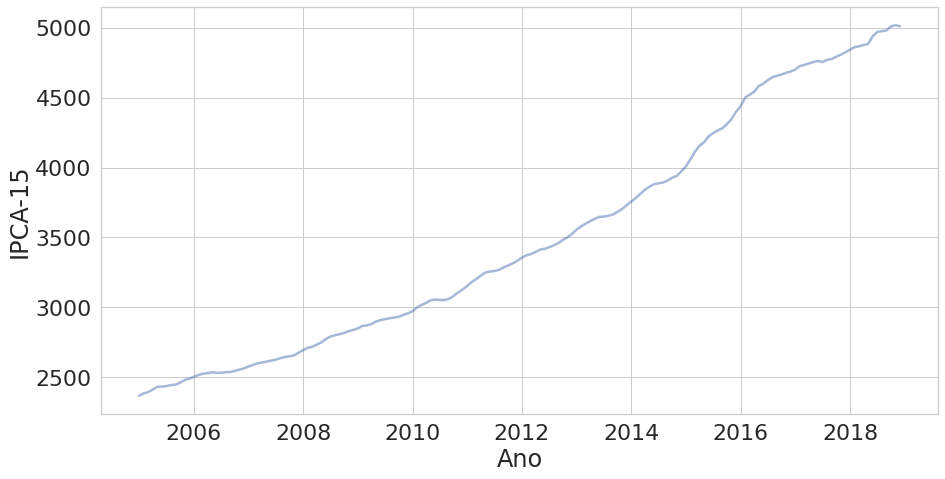

In [9]:
fig, ax = plt.subplots (figsize=(15, 7.5))
ax = sns.lineplot (data=df_inflacao, x='data', y='indice', alpha=.5, linewidth=2.5)
ax.xaxis.set_label_text ('Ano')
ax.yaxis.set_label_text ('IPCA-15')
plt.savefig ('./inflacao.png', dpi=400)

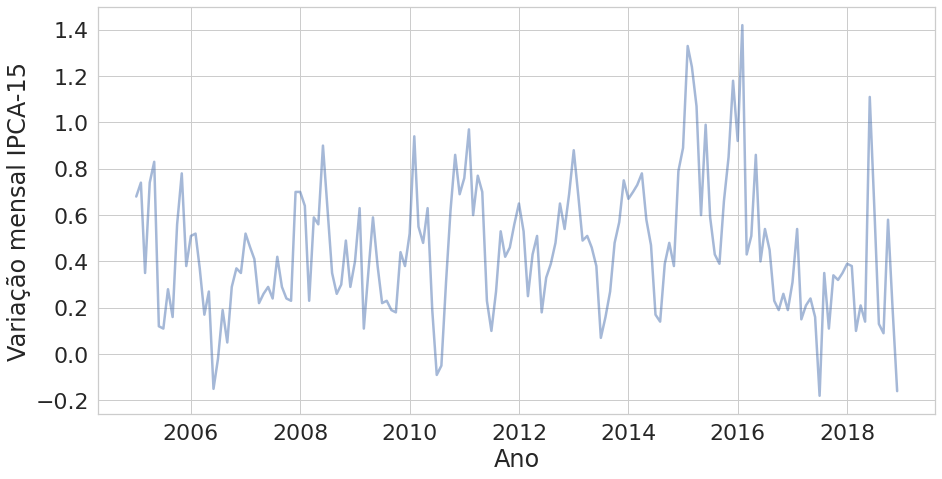

In [10]:
fig, ax = plt.subplots (figsize=(15, 7.5))
ax = sns.lineplot (data=df_inflacao, x='data', y='variacao_mes', alpha=.5, linewidth=2.5)
ax.xaxis.set_label_text ('Ano')
ax.yaxis.set_label_text ('Variação mensal IPCA-15')
plt.savefig ('./ipca_mensal.png', dpi=400)

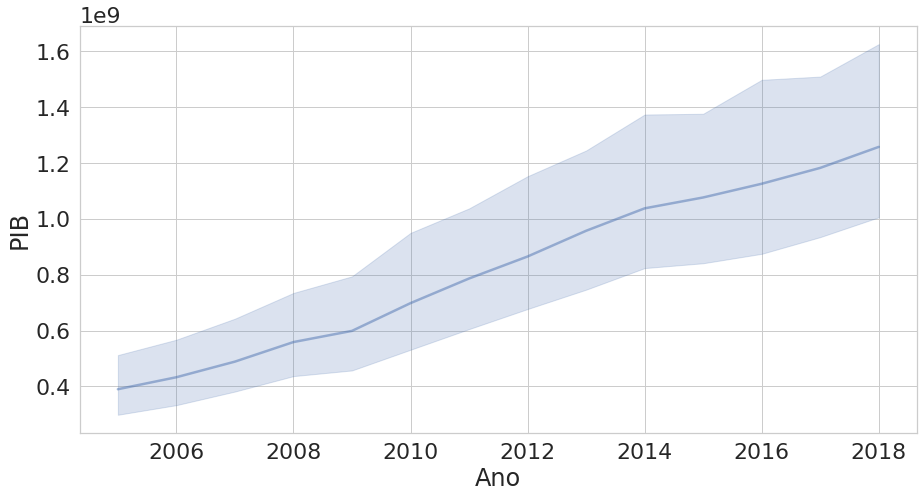

In [11]:
fig, ax = plt.subplots (figsize=(15, 7.5))
ax = sns.lineplot (data=df_pib, x='ano', y='PIB', alpha=.5, linewidth=2.5)
ax.xaxis.set_label_text ('Ano')
ax.yaxis.set_label_text ('PIB')
plt.savefig ('./pib.png', dpi=400)

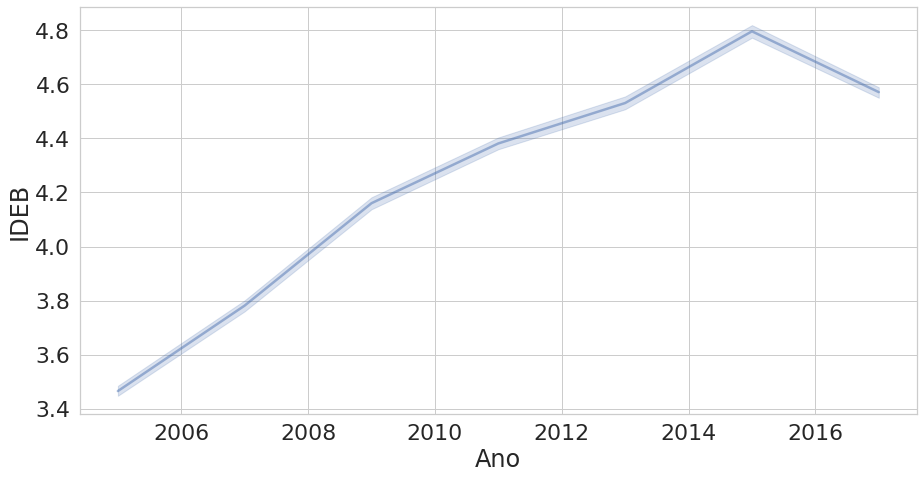

In [12]:
fig, ax = plt.subplots (figsize=(15, 7.5))
ax = sns.lineplot (data=df_ideb_municipio, x='ano', y='ideb', alpha=.5, linewidth=2.5)
ax.xaxis.set_label_text ('Ano')
ax.yaxis.set_label_text ('IDEB')
plt.savefig ('./ideb.png', dpi=400)

# Agregar as bases de dados de acordo com o atributo "id_municipio"

In [42]:
df = df_pib.merge (df_ideb_municipio, on=['id_municipio', 'ano'], how='inner')
df = df.merge (df_finbra_despesas_por_funcao, on=['id_municipio', 'ano'], how='inner')
df [:]

### K: Incluir os dados de inflação para o algoritmo.
df_final = df.merge (df_inflacao, on=['ano'], how='inner')

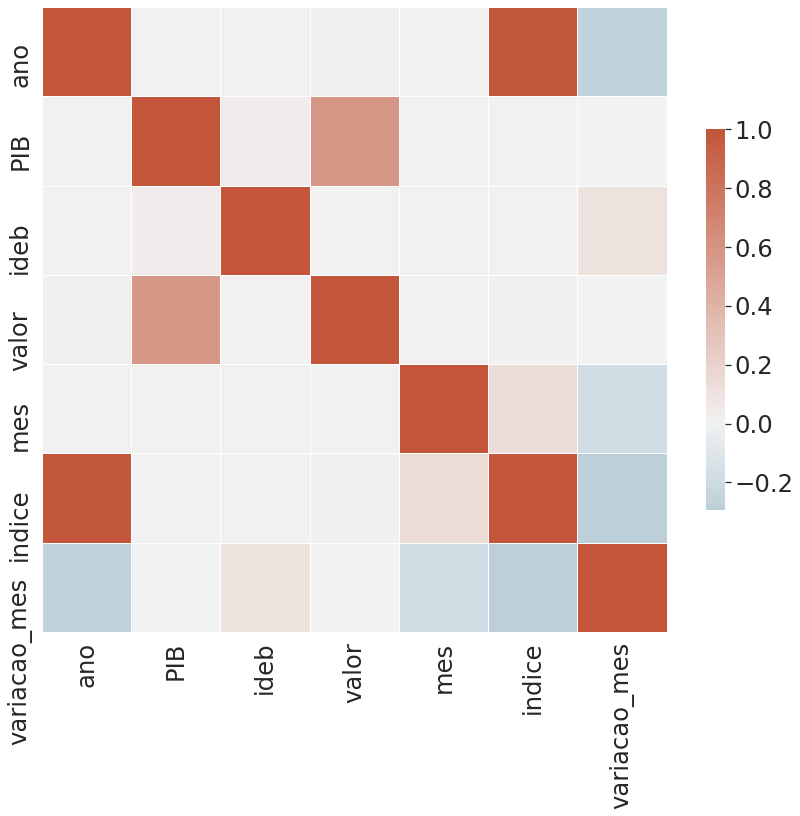

In [43]:
### K: Examinar possível correlação entre os dados.
try:
    df_sem_municipio = df.drop (axis = 'columns', columns = ['municipio', 'id_municipio'],)
except:
    pass ### K: Pra rodar a célula várias vezes.
    
corr = df_sem_municipio.corr ()
fig, ax = plt.subplots (figsize=(14, 14))
cmap = sns.diverging_palette (230, 20, as_cmap=True)
sns.set (font_scale=2.2)
sns.heatmap (corr,
             cmap=cmap,
             vmax=1, center=0,
             square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig ('./heatmap.png', dpi=500)

# Implementar e treinar o modelo de aprendizado

In [38]:

### K: Dropar nan.
df_final.dropna (inplace = True)

### K: Dropar atributos redundantes e atributos que possam tornar o modelo muito específico.
try:
    df_final.drop (axis = 'columns', columns = ['municipio', 'ano', 'mes', 'data'], inplace = True)
except:
    pass ### K: Pra rodar a célula várias vezes.

    
### K: Tratar atributos categóricos.
my_encoder = OrdinalEncoder ()
df_final ['tipo_de_gasto'] = my_encoder.fit_transform (df_final ['tipo_de_gasto'].values.reshape (-1, 1))

### K: Dividir o conjunto de dados.
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split (df_final.loc [:, df_final.columns != TARGET],
                                                                 df_final [TARGET],
                                                                 test_size = TEST_SIZE,
                                                                 random_state = STATE,)
print ('X_train_df shape:', X_train_df.shape)
print ('y_train_df shape:', y_train_df.shape)
print ('X_test_df shape:', X_test_df.shape)
print ('y_test_df shape:', y_test_df.shape)

X_train = X_train_df.values
y_train = y_train_df.values
X_test = X_test_df.values
y_test = y_test_df.values

df_final [:]

X_train_df shape: (525696, 6)
y_train_df shape: (525696,)
X_test_df shape: (131424, 6)
y_test_df shape: (131424,)


,id_municipio,PIB,ideb,tipo_de_gasto,valor,indice,variacao_mes
0,1100015,341324694,4.625000,3.0,11559592.81,3556.11,0.88
1,1100015,341324694,4.625000,3.0,11559592.81,3580.29,0.68
2,1100015,341324694,4.625000,3.0,11559592.81,3597.83,0.49
3,1100015,341324694,4.625000,3.0,11559592.81,3616.18,0.51
4,1100015,341324694,4.625000,3.0,11559592.81,3632.81,0.46
...,...,...,...,...,...,...,...
667291,5222302,182202882,5.633333,6.0,98483.03,4771.12,0.35
667292,5222302,182202882,5.633333,6.0,98483.03,4776.37,0.11
667293,5222302,182202882,5.633333,6.0,98483.03,4792.61,0.34
667294,5222302,182202882,5.633333,6.0,98483.03,4807.95,0.32


In [53]:
### K: Definir modelo de aprendizado.
scaler = StandardScaler ()
scaler.fit (X_train)
X_train = scaler.transform (X_train)
X_test = scaler.transform (X_test)

pf = PolynomialFeatures (degree=2)
pf = pf.fit (x_treino)
X_train_poly = pf.transform (X_train)
X_test_poly = pf.transform (X_test)
regressor_ridge = Ridge (alpha=50.0)
regressor_ridge = regressor_ridge.fit (X_train_poly, y_train)
y_predict_poly = regressor_ridge.predict (X_train_poly)
y_predict_test = regressor_ridge.predict (X_test_poly)

rmspe_in = np.sqrt(np.mean(np.square(((y_train - y_predict_poly) / y_train)),axis=0))
rmspe_out = np.sqrt(np.mean(np.square(((y_test - y_predict_test) / y_test)),axis=0))

print (rmspe_in)
print (rmspe_out)

0.1698921142405219
0.16947296729269384
